For the third part of predicting the ICU length of stay, we will perform a bag of words approach on the physician and nursing notes. This method will count up the frequency of word occurences as a predictors of ICU LOS.

NOTE: much of the code here is based on [this](https://blog.insightdatascience.com/introduction-to-clinical-natural-language-processing-c563b773053f) tutorial

To accomplish BOW, we need to do the following:
    1. split data into training/validation sets (because we only want to use train with words in the training set!)
    2. parse all of the words, removing \n or \r, and fill in missing notes with a space
    3. get all of the unique words in the training set
    4. count the number of times each word occurs for each row
    5. lemmatize / stem words (words ending with -ing, or pluarals, or past-tense should be counted as the same word)

In [112]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib as plt

In [113]:
# load in preprocessed data from part 2
df_icu = pd.read_csv('data/ICU_preprocessed.csv')

In [114]:
df_icu.head(0)

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,LOS,INTIME,OUTTIME,ETHNICITY_WHITE,ETHNICITY_BLACK,ETHNICITY_HISPANIC/LATINO,ETHNICITY_ASIAN,...,ADMIT_LOCATION_TRANSFER_FROM_HOSP/EXTRAM,ADMIT_LOCATION_TRANSFER_FROM_OTHER_HEALT,ADMIT_LOCATION_TRANSFER_FROM_SKILLED_NUR,INSURANCE_Government,INSURANCE_Medicaid,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Self_Pay,F,M


In [115]:
df_icu.OUTTIME = pd.to_datetime(df_icu.OUTTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_icu.INTIME = pd.to_datetime(df_icu.INTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

In [116]:
# get physician data
df_notes = pd.read_csv('data/NOTEEVENTS.csv')

/Users/lilyito/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [117]:
df_notes.head(0)

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT


View the types of notes there are

In [118]:
df_notes['CATEGORY'].unique()

array(['Discharge summary', 'Echo', 'ECG', 'Nursing', 'Physician ',
       'Rehab Services', 'Case Management ', 'Respiratory ', 'Nutrition',
       'General', 'Social Work', 'Pharmacy', 'Consult', 'Radiology',
       'Nursing/other'], dtype=object)

Extract physician and nursing notes (apparently some nursing notes ended up in nursing/other so extract that too)

Originally meant to only extract physician OR only nursing notes, but it turns out that they only have ~8000 entries each... which would mean missing out on a lot of data

In [119]:
df_notes_phys = df_notes.loc[(df_notes['CATEGORY']=='Physician ') | (df_notes['CATEGORY']=='Nursing') | (df_notes['CATEGORY']=='Nursing/other')  ][['ROW_ID','SUBJECT_ID','HADM_ID','CHARTTIME','TEXT']]

In [121]:
df_notes_phys.head(0)

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTTIME,TEXT


In [122]:
df_notes_phys.CHARTTIME = pd.to_datetime(df_notes_phys.CHARTTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

We want to match the times of the notes for each patient with the ICU in/out times. First merge the dataframes, then filter out the ones that aren't within the time frame. There is a possibility that the note is written after the ICU stay, but for simplicity, we'll stick with this.

In [123]:
df_joined = df_icu.merge(df_notes_phys,  how = 'inner', on = ['HADM_ID','SUBJECT_ID'])

In [124]:
df_joined = df_joined.query('CHARTTIME >= INTIME and CHARTTIME <= OUTTIME')

In [125]:
df_notes_grouped = df_joined.groupby(['SUBJECT_ID','HADM_ID','ICUSTAY_ID'], as_index = False).agg({'TEXT': ''.join})

In [127]:
df_notes_grouped.head(0)

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,TEXT


In [131]:
assert df_notes_grouped['ICUSTAY_ID'].nunique() == df_joined['ICUSTAY_ID'].nunique()

In [132]:
df_joined = pd.merge(df_icu, df_notes_grouped, on=['SUBJECT_ID','HADM_ID','ICUSTAY_ID'])
df_joined['ICUSTAY_ID'].nunique()

32740

In [134]:
df_joined.head(0)

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,LOS,INTIME,OUTTIME,ETHNICITY_WHITE,ETHNICITY_BLACK,ETHNICITY_HISPANIC/LATINO,ETHNICITY_ASIAN,...,ADMIT_LOCATION_TRANSFER_FROM_OTHER_HEALT,ADMIT_LOCATION_TRANSFER_FROM_SKILLED_NUR,INSURANCE_Government,INSURANCE_Medicaid,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Self_Pay,F,M,TEXT


# Splitting into train/validation sets
__IMPORTANT:__ because there are multiple ICU stays per person, we need to make sure the same person does not get split between the train/test sets. This is important for preventing data leakage

In [169]:
import sklearn
from sklearn.model_selection import GroupShuffleSplit


y = df_joined['LOS']
X = df_joined.drop(['LOS'], axis = 1)

group = df_joined['SUBJECT_ID']

train_inds, test_inds = next(GroupShuffleSplit(test_size=0.33, n_splits=2, random_state = 7).split(df_joined, groups=df_joined['SUBJECT_ID']))

X_train = X.iloc[train_inds]
X_test = X.iloc[test_inds]
y_train = y.iloc[train_inds]
y_test = y.iloc[test_inds]

In [137]:
X_merge = X_train.merge(X_test, how='inner', on=['SUBJECT_ID','HADM_ID','ICUSTAY_ID'])

In [142]:
# check that there were no subjects after using an inner merge
X_merge

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,INTIME_x,OUTTIME_x,ETHNICITY_WHITE_x,ETHNICITY_BLACK_x,ETHNICITY_HISPANIC/LATINO_x,ETHNICITY_ASIAN_x,ETHNICITY_NATIVE_x,...,ADMIT_LOCATION_TRANSFER_FROM_OTHER_HEALT_y,ADMIT_LOCATION_TRANSFER_FROM_SKILLED_NUR_y,INSURANCE_Government_y,INSURANCE_Medicaid_y,INSURANCE_Medicare_y,INSURANCE_Private_y,INSURANCE_Self_Pay_y,F_y,M_y,TEXT_y


# BOW

In [143]:
import nltk
import string 
from nltk import word_tokenize
from nltk.stem import PorterStemmer

We are creating our own tokenizer, which will take strings and break them up at each space so each word is a token. We'll also use a porter stemmer to lemmatize like words. We'll also remove punctuation and any numbers.

In [144]:
def new_tokenizer(text):
    ps = PorterStemmer()
    # create a dictionary mapping of characters 
    # we want to replace with what to replace with
    punc_list = string.punctuation+'0123456789'
    # maketrans() creates a mapping of the character's Unicode ordinal 
    t = text.maketrans(dict.fromkeys(punc_list, " "))
    text = text.lower().translate(t)
    tokenized = word_tokenize(text)
    
    tokenized_stemmed = [ps.stem(word) for word in tokenized]
    
    return tokenized_stemmed

In [145]:
# Example:
new_tokenizer('These strings shoulD be tokenized 1/15/2021!!')

['these', 'string', 'should', 'be', 'token']

Now we will use a count vectorizer to learn the words in the traning data (fit) and transform the data so it creates counts for each word, constrain # of words included in vectorizer which will use the top N most frequently used words

In [146]:
%time
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(max_features = 3000, tokenizer = new_tokenizer)

vect.fit(X_train.TEXT.values)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 523 µs


/Users/lilyito/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


CountVectorizer(max_features=3000,
                tokenizer=<function new_tokenizer at 0x7fe27f1b9950>)

In [147]:
# get counts for each word
doc_matrix = vect.transform(X_train.TEXT.values)
term_freq = np.sum(doc_matrix, axis = 0)

In [148]:
tf = np.squeeze(np.asarray(term_freq))

In [149]:
tf = np.squeeze(np.asarray(term_freq))
tf_df = pd.DataFrame([tf], columns = vect.get_feature_names()).transpose()
tf_df.columns = ['tf']
tf_df.sort_values(by='tf',ascending = False)

,tf
to,2793268
and,2508779
with,1689030
of,1554124
pt,1373463
...,...
teeth,2399
hn,2397
adl,2394
wheezi,2391


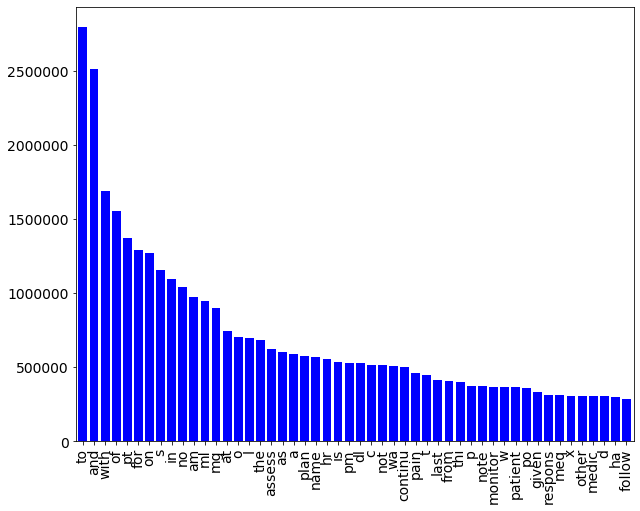

In [150]:
d = pd.Series(tf_df.tf, index = tf_df.index).sort_values(ascending = False)
ax = d[:50].plot(kind='bar', figsize=(10,8), width=.8, fontsize=14, rot=90, color = 'b')
ax.title.set_size(18)

In [151]:
stop_words=['to','and','with','of','pt','for','on','s','in','ml','mg','o',
            'at','the','l','as','a','pm','is','dl','he','she','q','h','by','his',
            'her','k','be','but','was','name','patient','am','there','that','are',
            'an','also', 'c','t']

In [152]:
# add in the stop words and refit
vect = CountVectorizer(max_features = 3000, 
                       tokenizer = new_tokenizer, 
                       stop_words = stop_words)

vect.fit(X_train.TEXT.values)

/Users/lilyito/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/Users/lilyito/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['hi', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


CountVectorizer(max_features=3000,
                stop_words=['to', 'and', 'with', 'of', 'pt', 'for', 'on', 's',
                            'in', 'ml', 'mg', 'o', 'at', 'the', 'l', 'as', 'a',
                            'pm', 'is', 'dl', 'he', 'she', 'q', 'h', 'by',
                            'his', 'her', 'k', 'be', 'but', ...],
                tokenizer=<function new_tokenizer at 0x7fe27f1b9950>)

In [170]:
X_train_text = vect.transform(X_train.TEXT.values)
X_test_text = vect.transform(X_test.TEXT.values)

In [171]:
from sklearn.feature_extraction.text import TfidfVectorizer
print(len(vect.get_feature_names()))

vect.get_feature_names()

3000


['aaa',
 'aaox',
 'ab',
 'abcess',
 'abd',
 'abdomen',
 'abdomin',
 'abg',
 'abil',
 'abl',
 'ablat',
 'abnorm',
 'about',
 'abov',
 'abp',
 'abras',
 'abscess',
 'absent',
 'abus',
 'abx',
 'ac',
 'accept',
 'access',
 'accessori',
 'accid',
 'accord',
 'accordingli',
 'ace',
 'acei',
 'acetaminophen',
 'ach',
 'achiev',
 'acid',
 'acidosi',
 'acquir',
 'act',
 'action',
 'activ',
 'acut',
 'acyclovir',
 'ad',
 'add',
 'addendum',
 'addit',
 'address',
 'adenopathi',
 'adeq',
 'adequ',
 'adhes',
 'adjust',
 'adl',
 'adm',
 'admin',
 'administ',
 'administr',
 'admiss',
 'admit',
 'adren',
 'advair',
 'advanc',
 'aerat',
 'aerosol',
 'af',
 'afeb',
 'afebril',
 'affect',
 'afib',
 'aflutt',
 'after',
 'afternoon',
 'ag',
 'again',
 'against',
 'age',
 'agent',
 'aggit',
 'aggress',
 'agit',
 'ago',
 'agre',
 'aicd',
 'aid',
 'air',
 'airleak',
 'airway',
 'alarm',
 'alb',
 'albumin',
 'albuterol',
 'alcohol',
 'alert',
 'alin',
 'alk',
 'alkalosi',
 'all',
 'allergi',
 'allopurinol',
 

In [172]:
X_train_text

<21896x3000 sparse matrix of type '<class 'numpy.int64'>'
	with 11291453 stored elements in Compressed Sparse Row format>

In [173]:
# drop identifier columns and then combine ICU data with BOW data
X_train = X_train.drop(['TEXT','SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID','INTIME', 'OUTTIME'], axis=1)
X_test = X_test.drop(['TEXT','SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID','INTIME', 'OUTTIME'], axis = 1)

In [174]:
from scipy.sparse import hstack
X_train_sparse = hstack([X_train, X_train_text])
X_test_sparse = hstack([X_test, X_test_text])

In [175]:
X_train_list = X_train.columns.tolist()

In [176]:
feature_names = X_train_list + vect.get_feature_names() 

In [177]:
#save data

import 

scipy.sparse.save_npz('data/X_train_sparse.npz', X_train_sparse)
scipy.sparse.save_npz('data/X_test_sparse.npz', X_test_sparse)

import pickle
with open("data/feature_names.txt", "wb") as fp:
    pickle.dump(feature_names, fp)

with open("data/y_train.txt", "wb") as fp:
    pickle.dump(y_train, fp)
    
with open("data/y_test.txt", "wb") as fp:
    pickle.dump(y_test, fp)

NameError: name 'scipy' is not defined